<a href="https://colab.research.google.com/github/plassi/karhuntunnistin/blob/main/konenako_v1_0_clean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Konenäkö v1.0 - osa 1 - Karhuntunnistin konvoluutioisella neuroverkolla

Luvun tekstit ovat blogissa.

## Karhuntunnistin





## Hieman teoriaa

### Keinotekoinen neuroni

### Konvoluutioinen neuroverkko

# Perustyökalut

## Google Colab

## Asennus ja kirjastojen tuonti

In [ ]:
# Asennetaan aluksi fast.ai:n fastbook
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 6.1MB/s 
     |████████████████████████████████| 194kB 9.0MB/s 
     |████████████████████████████████| 1.2MB 12.5MB/s 
     |████████████████████████████████| 51kB 8.4MB/s 
     |████████████████████████████████| 61kB 10.4MB/s 
     |████████████████████████████████| 51kB 8.7MB/s 
Mounted at /content/gdrive


In [ ]:
# Tuodaan tarvittavat kirjastot käyttöön
from fastbook import *
from fastai.vision.widgets import *

## Jupyter Notebook ja IPython

In [ ]:
# fast.ai:n tarjoama funktio kuvien hakuun Bingistä
search_images_bing

<function fastbook.search_images_bing>

In [ ]:
# doc() on fastbookin tarjoama kirjasto
doc(search_images_bing)

# Datan hakeminen

## Bing Image API

In [ ]:
# Liitetään Bing-haun APIin
key = os.environ.get('AZURE_SEARCH_KEY', 'XXX')

## Testikuvan haku Bingistä

In [ ]:
# Tehdään haku
results = search_images_bing(key, 'karhu', max_images=150)
ims = results.attrgot('contentUrl')
len(ims)

150

In [ ]:
# Luodaan kansio kuvalle, jos sitä ei ole vielä olemassa
if not Path('images').exists():
  Path('images').mkdir()

In [ ]:
# Ladataan edellisessä luotuun kansioon yksi kuva hakutuloksista
dest = 'images/karhu.jpg'
download_url(ims[0], dest)

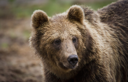

In [ ]:
# Näytetään ladatusta kuvasta pieni versio. Muista ajaessasi koodia että kyseessö on verkkohaku ja tulosten laadusta ei ole varmuutta.
im = Image.open(dest)
im.to_thumb(128,128)

## Datan lataaminen Bingistä

In [ ]:
# Määritetään karhulajit
bear_types = 'brown','polar','teddy'
path = Path('bears')

In [ ]:
# Haetaan hakusanoilla ja ladataan hakutulokset hakusanan mukaisiin kansioihin
if not path.exists():
    path.mkdir()
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} bear', max_images=150)
        download_images(dest, urls=results.attrgot('contentUrl'))

In [ ]:
# Haetaan ladatut kuvatiedostot listaan
fns = get_image_files(path)
fns

(#408) [Path('bears/brown/00000022.jpg'),Path('bears/brown/00000041.jpg'),Path('bears/brown/00000108.jpg'),Path('bears/brown/00000001.jpg'),Path('bears/brown/00000149.jpg'),Path('bears/brown/00000113.jpeg'),Path('bears/brown/00000033.jpg'),Path('bears/brown/00000147.jpg'),Path('bears/brown/00000117.jpg'),Path('bears/brown/00000115.jpg')...]

In [ ]:
# Selvitetään, mitkä tiedostot eivät avaudu kuvina
failed = verify_images(fns)
failed

(#5) [Path('bears/brown/00000048.jpg'),Path('bears/polar/00000125.jpg'),Path('bears/teddy/00000068.jpg'),Path('bears/teddy/00000128.jpg'),Path('bears/teddy/00000035.jpg')]

In [ ]:
# Poistetaan epäonnistuneet lataukset
failed.map(Path.unlink);

In [ ]:
# Kaikkien kuvatiedostojen poisto
'''
fns = get_files(path)
for kuva in fns:
  kuva.unlink()
'''

# DataLoader

In [ ]:
# Tehdään bears-niminen DataLoader
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

## Datan augmentointi

In [ ]:
# Tuotetaan neuroverkolle lisää koulutusdataa tekemällä kuviin satunnaisia rajauksia ja kääntöjä
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

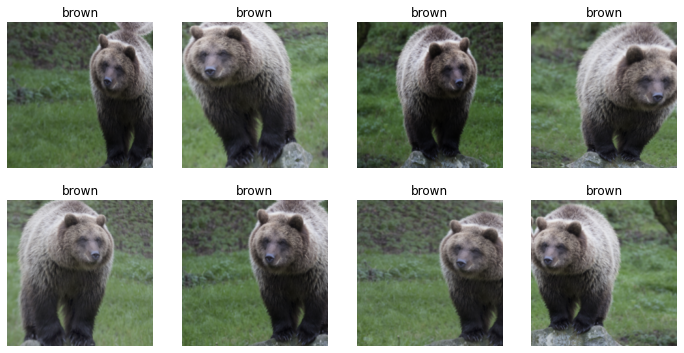

In [ ]:
# Näytetään esimerkki muokatuista kuvista
dls.train.show_batch(max_n=8, nrows=2, unique=True)

# Neuroverkon kouluttaminen

In [ ]:
# Neuroverkon koulutus
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

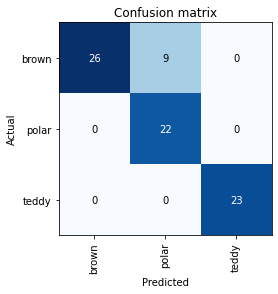

In [ ]:
# Esitetään Confusion matrix
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

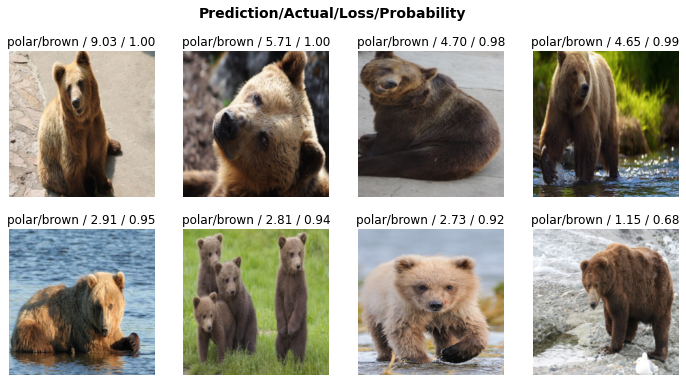

In [ ]:
interp.plot_top_losses(8, nrows=2)

# Datan puhdistaminen

In [ ]:
# Datan puhdistustyökalu
cleaner = ImageClassifierCleaner(learn)
cleaner

In [ ]:
# Tee cleanerissä valitut toiminnot
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

# Mallin koulutus uudelleen

In [ ]:
# Tehdään bears-niminen DataLoader
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    )


# Määritetään dataloaderit
dls = bears.dataloaders(path)

# Neuroverkon koulutus
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(2)


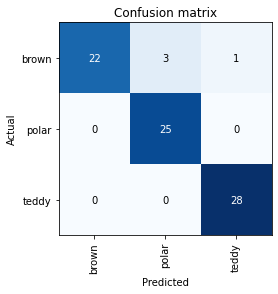

In [ ]:
# Esitetään Confusion matrix
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

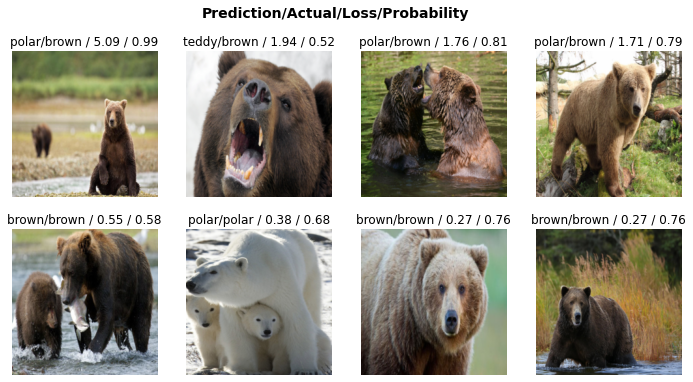

In [ ]:
interp.plot_top_losses(8, nrows=2)

# Valmis malli

## Mallin vienti ja tuonti tiedostona

In [ ]:
# Valmistele malli vientiä varten
learn.export()

In [ ]:
# Tallenna malli .pkl-tiedostona
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [ ]:
# lataa malli käyttöön
learn_inf = load_learner(path/'export.pkl')

## Mallin testaaminen

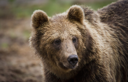

In [ ]:
# Artikkelin alussa ladatun testikuvan pikkukuva
im.to_thumb(128,128)

In [ ]:
# Kokeile mallia testikuvan tiedostoon
learn_inf.predict('images/karhu.jpg')

('brown', tensor(0), tensor([0.9760, 0.0205, 0.0035]))